In [2]:
import numpy as np

from scipy import ndimage
from PIL import Image
import dlib
import cv2

from sklearn.decomposition import PCA
from skimage import feature

from matplotlib import pyplot as plt

import glob,os

In [3]:
def preprocesing_images(path_="dataset"):
    """
    getting file names of all images from folder 'path_'
    Arguments:
    path_ -- path to folder with dataset, default value='dataset'

    Return:
    files -- list of file names
    """
    path_="dataset/*/*.pgm"
    files=glob.glob(path_)
    return files

photo size: (112, 92)
Image sample:


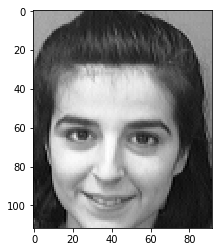

In [4]:
#getting file names of all images in folder "dataset"
files= preprocesing_images(path_="dataset")
sample=files[10]
img=np.array(Image.open(sample))
print(f'photo size: {img.shape}')
print('Image sample:')
plt.imshow(img, cmap='gray')

In [5]:
# set parametrs for model
rows=len(files)
height=img.shape[0]
width=img.shape[1]
columns=height*width

In [6]:
def create_data_matrix(files,rows,columns):
    """
    This method vectorizes images and creates matrix with shape (rows,columns).
    Where 'rows' - number of images and 'columns' - number of features (features=image height * image width)
    
    Arguments:
    files -- list of file names
    rows -- number of images
    columns -- number of features
    
    """
    row=0
    labels=[]
    data=np.zeros((rows,columns))
    for f in files:
        im=np.array(Image.open(f))
        im=im.reshape(1,im.shape[0]*im.shape[1])
   
        #create dataset: "data"
        data[row,:]=im
        row+=1
   
        #create labels for images: "labels"
        fname,ext = os.path.splitext(f)
        _,name,index, = fname.split('\\')
        labels.append(int(name[1:]))
    labels=np.array(labels).reshape(len(labels),1)
    return data, labels

In [7]:
#creating dataset from images: data and labels
data, labels = create_data_matrix(files,rows,columns)
print(f'Dataset shape: {data.shape}')
print(f'Labels shape: {labels.shape}')

Dataset shape: (400, 10304)
Labels shape: (400, 1)


In [8]:
def vec_to_image(v,w=(height,width)):
    """
    Convert image vector into image array
    
    Arguments:
    v -- image vector
    w -- array size for reshaping [height, width]
    
    Return:
    img -- converted vector into array
    
    """
    img=v.reshape(w[0],w[1])
    return img

def show_image(ind,data,labels,size=(height,width)):
    """
    Show image and label from dataset.
    
    Arguments:
    ind -- index of image in dataset
    data -- matrix of dataset
    labels -- labels of images from dataset
    size -- pixel size of image.
    """
    img=vec_to_image(data[ind],size)
    plt.imshow(img, cmap='gray')
    plt.title(f'label: {np.squeeze(labels)[ind]}')

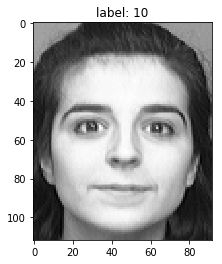

In [9]:
#test, select and show photo with index=11
index=11
show_image(index,data,labels)

In [10]:
def select_index(ind1, ind2):
    """
    selct ind1 and ind2 images from each employee
    Arguments:
    
    ind1 -- index first image for each employee
    ind2 -- index second image for each employee
    
    Return:
    test_index -- indices for test dataset, where we have 80 images (2 images for each employee * 40 employee)
    
    """
    ind1=ind1-1 #for correct indexing in array, where first element has index 0
    ind2=ind2-1
    ind1=[i+10 for i in range(ind1-10,390,10)]
    ind2=[i+10 for i in range(ind2-10,390,10)]
    test_index=np.concatenate((ind1,ind2))
    return test_index

In [11]:
def split_dataset(data,ind1=9, ind2=10):
    """
    Split data to train and test.
    Arguments:
    data -- dataset matrix
    ind1, ind2 -- index for selection test dataset
    
    Return:
    train_set -- train dataset
    train_labels -- labels for train dataset
    test_set -- test dataset
    test_labels - labels for test dataset
    
    """
    #create indices for test dataset
    index=select_index(ind1, ind2)
    
    #create test dataset
    test_set=data[index,:]
    test_labels=labels[index]
    
    #create train data_set
    train_set=np.delete(data,index,axis=0)
    train_labels=np.delete(labels,index)
    train_labels=train_labels.reshape(len(train_labels),1)
    
    return train_set, train_labels, test_set, test_labels 

In [12]:
# split data to train and test
train_set, train_labels, test_set, test_labels = split_dataset(data)
print(f'Train set shape: {train_set.shape}, train labels shape: {train_labels.shape}')
print(f'Test set shape: {test_set.shape}, test labels shape: {test_labels.shape}')
train_orginal=train_set
test_original=test_set

Train set shape: (320, 10304), train labels shape: (320, 1)
Test set shape: (80, 10304), test labels shape: (80, 1)


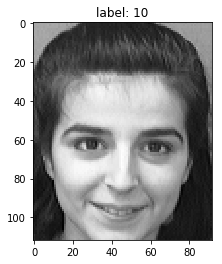

In [13]:
show_image(10,train_set,train_labels)

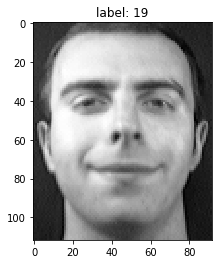

In [14]:
show_image(10,test_set,test_labels)

In [15]:
# load unknown photos and identify employee
def identify_employee(train_set,unknown_set):
    """
    This method use MSE algorithm and identify employee.
    
    Arguments:
    train_set -- train dataset
    unknown_set -- vectorized photos that we have to recognize (test data set)
    
    Returns:
    predict_index -- vector of indices, that predict labels of test dataset images
    """
    min_dist=[]
    for ind in range(unknown_set.shape[0]):
        dist=np.linalg.norm(train_set-unknown_set[ind,:],axis=1,keepdims=True)
        min_dist.append(np.argmin(dist))
    predict_index=np.array(min_dist).reshape(len(min_dist),1)
    return predict_index

def accuracy(train_labels,test_labels, predict_index, index=1):
    """
    Calculate accuracy.
    
    Arguments:
    train_label -- labels for train dataset
    test_labels -- labels for test dataset
    predict_index -- vector of indices, that predict labels of test dataset images
    index -- it uses for distinguishing usual algorithm and PCA, where accuracy receives labels insted of index
    
    Returns:
    acc -- accuracy
    err_index -- error indices
    true_index -- true indices
    """
    if index:
        yhat=np.squeeze(train_labels[predict_index])
    else:
        yhat=predict_index
    ytest=np.squeeze(test_labels)
    compare=yhat==ytest
    err_index=np.where(compare==False)
    true_index=np.where(compare==True)
    true_answ=sum(compare)
    acc = (true_answ/test_labels.shape[0])*100     
    return acc,err_index,true_index

def show_errors(train_set,train_labels,test_set,test_labels,predict_index,err_index,figsize=(10,10),index=1,
                X=train_orginal,X_test=test_original):
    """
    This additional method that helps to display errors of recognition or true answers of model.
    """
    n=1
    if len(err_index[0])<=1:
        l=1
        print('Predict photo                          Real photo')
        plt.figure(figsize=figsize)
        plt.subplot(l,2,n)
        if index==True:
            show_image(predict_index[err_index],train_set,train_labels)
        else:
            show_image(np.where(train_labels==predict_index[err_index])[0][0],train_set,train_labels)
        n+=1
        plt.subplot(l,2,n)
        show_image(err_index,test_set,test_labels)  
    else:
        err_index=np.squeeze(err_index)
        l=err_index.shape[0]
        print('Predict photo                          Real photo')
        plt.figure(figsize=figsize)
        for i in err_index:
            plt.subplot(l,2,n)
            if index==1:
                show_image(predict_index[i],train_set,train_labels)
            elif index==2:
                show_image(np.where(train_labels==predict_index[i])[0][0],train_set,train_labels)
            elif index==3:
                show_image(predict_index[i],X,train_labels)
                           
            n+=1
            plt.subplot(l,2,n)
            if index==3:
                show_image(i,X_test,test_labels)
            else:
                show_image(i,test_set,test_labels)
            n+=1

In [16]:
def model_face_recognition(train_set,train_labels,test_set,test_labels,
                           show_err=True,show_correct=False,figsize=(10,10), index=1, norm=0, axis=0,
                           pca_flag=False, pca_energy=0.98, lbp_flag=False):
    
    """
    This function recognise face.
    
    Arguments:
    train_set -- train dataset
    train_labels -- labels for train dataset
    test_set -- test dataset
    test_labels - labels for test dataset
    show_err -- flag for showing recognation errors, default value = True
    show_correct -- flag for showing samples of corect recognition, default value = False
    figsize -- figsize for displaying errors ot true answers
    index -- type of image processing for method show_erros, default value=1
    norm -- type of normalization. 1 - substract mean, 2 - standardize data, 0 - without normalization
    axis -- axis of normalization
    pca_flag -- turn on PCA
    pca_energy -- coefficient of explained bariance, default value=0.98
    
    Return:
    acc -- Accuracy
    """
    #Normalization
    if norm==1:
        train_set=subtract_mean(train_set, axis=axis)
        test_set=subtract_mean(test_set, axis=axis)
    elif norm==2:
        train_set=standard_norm(train_set, axis=axis)
        test_set=standard_norm(test_set, axis=axis)
        
        
    if pca_flag:
        train_set, test_set, n_components=pca_model(train_set, test_set, pca_energy=pca_energy, kind_normalize=norm)
        
    predict_index=identify_employee(train_set,test_set)
    
    acc,err_index,true_index=accuracy(train_labels,test_labels, predict_index,index=index)
    print(f'Accuracy for test dataset = {acc}')
    #Error visualization
    if show_err:
        show_errors(train_set,train_labels,test_set,test_labels,predict_index,err_index,index=index,figsize=figsize)
    if show_correct:
        show_errors(train_set,train_labels,test_set,test_labels,predict_index,true_index,index=index,figsize=(10,90))
    return acc

Accuracy for test dataset = 96.25
Predict photo                          Real photo


96.25

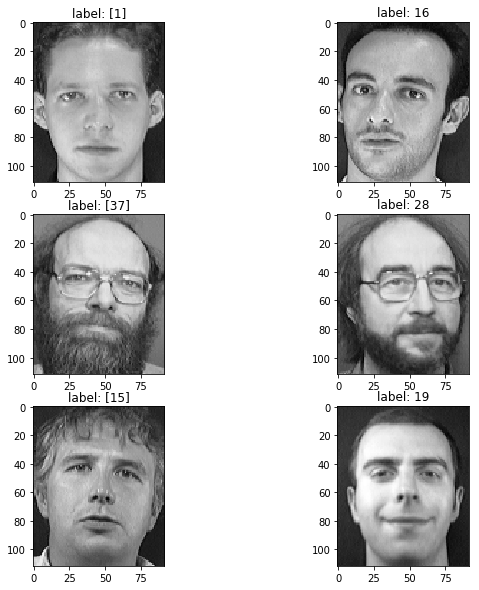

In [17]:
# Result without normalization
model_face_recognition(train_set,train_labels,test_set,test_labels,show_err=True)

Accuracy for test dataset = 96.25
Predict photo                          Real photo


96.25

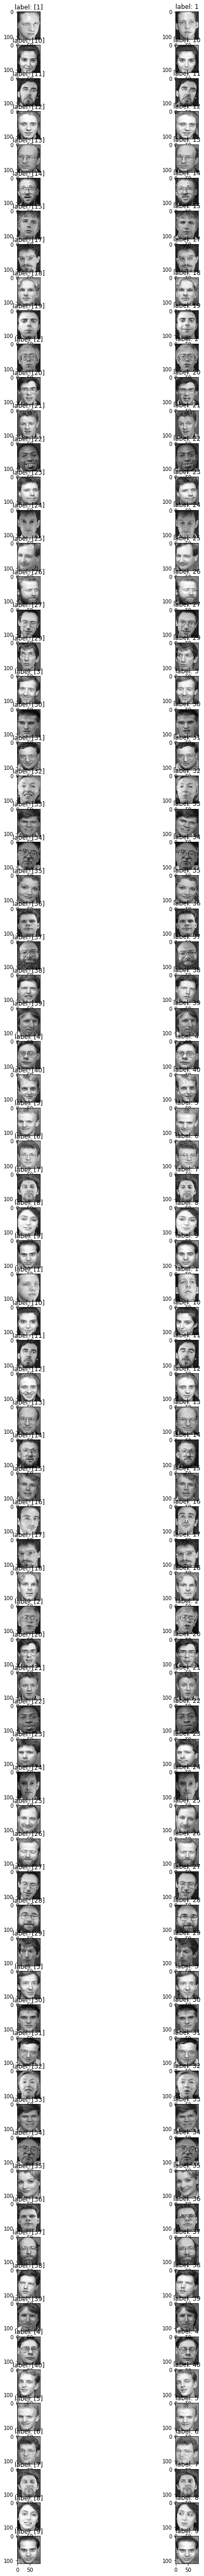

In [18]:
#demonstration how model can identify emploee
model_face_recognition(train_set,train_labels,test_set,test_labels,show_err=False,show_correct=True)

In [19]:
# make shuffle for train dataset and define accuracy
index_shuffle=np.arange(train_set.shape[0])
np.random.shuffle(index_shuffle)
model_face_recognition(train_set,train_labels,train_set[index_shuffle],train_labels[index_shuffle],show_err=False)

Accuracy for test dataset = 100.0


100.0

## Optimization / Normalization steps

In [20]:
#subtract mean value from the feature
def subtract_mean(x,axis=0):
    """
    Data normalizatin: x-x.mean
    Argument:
    x - matrix, dataset
    Return:
    Normalized dataset
    """
    return x-x.mean(axis=axis,keepdims=True)

# standard score: (X-mu)/sigma
def standard_norm(X,axis=0):
    """
    Data normalizatin: (x-x.mean)/s.std
    Argument:
    x - matrix, dataset
    Return:
    Normalized dataset
    """
    A=(X-X.mean(axis=1, keepdims=True))/X.std(axis=axis, keepdims=True)
    return A

In [21]:
# Accuracy for normalized dataset, method - subtract_mean
print('Normalization by features')
model_face_recognition(train_set,train_labels,test_set,test_labels,show_err=False,norm=1,axis=0)
print('Normalization by samples')
model_face_recognition(train_set,train_labels,test_set,test_labels,show_err=False,norm=1,axis=1)

Normalization by features
Accuracy for test dataset = 95.0
Normalization by samples
Accuracy for test dataset = 95.0


95.0

In [22]:
#Accuracy didn't change, after normalization through subtraction mean from each feature

In [23]:
# Accuracy for normalized dataset, method - standard score: (X-mu)/sigma
print('Normalization by features')
model_face_recognition(train_set,train_labels,test_set,test_labels,show_err=False,norm=2,axis=0)
print('Normalization by samples')
model_face_recognition(train_set,train_labels,test_set,test_labels,show_err=False,norm=2,axis=1)

Normalization by features
Accuracy for test dataset = 93.75
Normalization by samples
Accuracy for test dataset = 95.0


95.0

In [24]:
# Accuracy become worse after applying standardization of dataset

### Table of different types normalization and corresponding accuracy
| Accuracy | subtract_mean | standard_norm |
| --- | --- | --- |
| by features | 95 | 93.75 |
| by samples | 95 | 95 |

## End

## Additional method that were used in this project

## PCA

In [25]:
pca_energy_list=list([0.95, 0.98, 0.99, 1.00])
pca_energy=0.98

In [26]:
# kind_normalize='subtract_mean' or standard_norm
def pca_model(train_set, test_set, pca_energy=0.98, kind_normalize=1):
    if kind_normalize==1:
        #data normalization
        train_set_norm=subtract_mean(train_set)
        test_set_norm=subtract_mean(test_set)
    else:
        train_set_norm=standard_norm(train_set)
        test_set_norm=standard_norm(test_set)
    
    #fit pca on training set
    pca=PCA(pca_energy)
    pca.fit(train_set_norm)
    print(f"PCA components = {pca.n_components_}, explained variance = {pca_energy}")
    
    #transform train and test sets
    train_transform=pca.transform(train_set_norm)
    test_transform=pca.transform(test_set_norm)
    
    print(f'New shape of train_set after applying PCA method = {train_transform.shape}')
    print(f'New shape of test_set after applying PCA method = {test_transform.shape}')
    return train_transform, test_transform, pca.n_components_

PCA components = 229, explained variance = 0.98
New shape of train_set after applying PCA method = (320, 229)
New shape of test_set after applying PCA method = (80, 229)
Accuracy for test dataset = 95.0
Predict photo                          Real photo


95.0

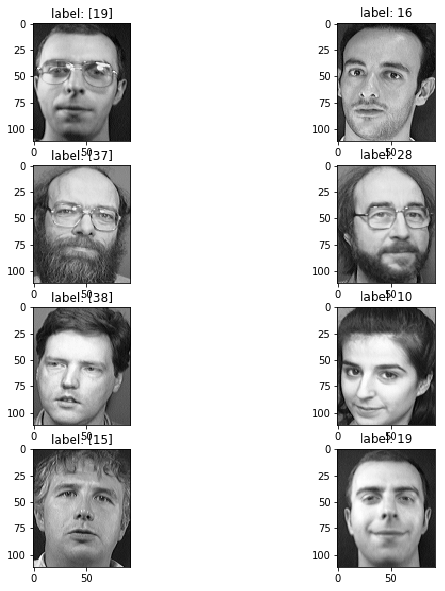

In [27]:
model_face_recognition(train_set,train_labels,test_set,test_labels,show_err=True,index=3,pca_flag=1,
                      pca_energy=0.98,norm=1)

One of the most important applications of PCA is for speeding up machine learning algorithms.In this case 98% of the variance amount to 230 principal components.
Accuracy don't change and equal 95%

In [28]:
#Let's change pca_energy 0.95, 0.99, 1.00
model_face_recognition(train_set,train_labels,test_set,test_labels,show_err=False,index=3,pca_flag=1,
                      pca_energy=0.95,norm=1)

PCA components = 161, explained variance = 0.95
New shape of train_set after applying PCA method = (320, 161)
New shape of test_set after applying PCA method = (80, 161)
Accuracy for test dataset = 95.0


95.0

In [29]:
model_face_recognition(train_set,train_labels,test_set,test_labels,show_err=False,index=3,pca_flag=1,
                      pca_energy=0.99,norm=1)

PCA components = 264, explained variance = 0.99
New shape of train_set after applying PCA method = (320, 264)
New shape of test_set after applying PCA method = (80, 264)
Accuracy for test dataset = 95.0


95.0

In [30]:
model_face_recognition(train_set,train_labels,test_set,test_labels,show_err=False,index=3,pca_flag=1,
                      pca_energy=0.999,norm=1)

PCA components = 311, explained variance = 0.999
New shape of train_set after applying PCA method = (320, 311)
New shape of test_set after applying PCA method = (80, 311)
Accuracy for test dataset = 96.25


96.25

Accuracy don't change and equal 95%. Accuracy reduces only when pca_energy <= 0.5

### LBP (Local Binary Pattern)

In [31]:
def lbp_describe(img,numPoints=8,radius=2):
    img_lbp=feature.local_binary_pattern(img,numPoints,radius)
    hist,_=np.histogram(img_lbp.ravel(),bins=np.arange(0, numPoints + 3), range=(0, numPoints + 2))
    return hist,img_lbp.ravel()

Text(0.5, 1.0, 'LBP_transformation')

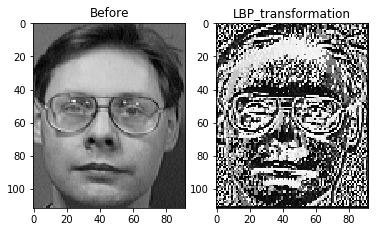

In [32]:
# Demonstarion of LBP transformation
path_="dataset/s4/1.pgm"
img=cv2.imread(path_, cv2.COLOR_BGR2GRAY)
plt.subplot(121)
plt.imshow(img,cmap='gray')
plt.title('Before')
plt.subplot(122)
img_lbp=feature.local_binary_pattern(img,9,1)
plt.imshow(img_lbp, cmap='gray')
plt.title('LBP_transformation')

In [33]:
def create_data_matrix_lbp(files,rows,columns,numPoints=8,radius=2,hist=False):
    row=0
    labels=[]
    if hist:
        columns = numPoints + 2
    data=np.zeros((rows,columns))
    for f in files:
        if not(hist):
            img=np.array(Image.open(f))
            _,img=lbp_describe(img,numPoints=numPoints,radius=radius)
        if hist:
            img=np.array(Image.open(f))
            img,_=lbp_describe(img,numPoints=numPoints,radius=radius)
              
        #create dataset: "data"
        data[row,:]=img
        row+=1
        #create labels for images: "labels"
        fname,ext = os.path.splitext(f)
        _,name,index, = fname.split('\\')
        labels.append(int(name[1:]))
    labels=np.array(labels).reshape(len(labels),1)
    return data, labels

In [34]:
# Transform all images using LBT transformation
data_lbt, labels = create_data_matrix_lbp(files,rows,columns,numPoints=24,radius=12,hist=False)

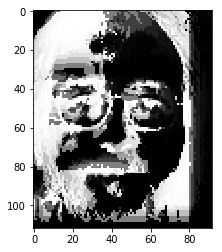

In [35]:
plt.imshow(data_lbt[200].reshape(112,92),cmap='gray')

In [36]:
# split data to train and test
train_lbt, train_labels, test_lbt, test_labels = split_dataset(data_lbt)
print(f'Train set shape: {train_lbt.shape}, train labels shape: {train_labels.shape}')
print(f'Test set shape: {test_lbt.shape}, test labels shape: {test_labels.shape}')

Train set shape: (320, 10304), train labels shape: (320, 1)
Test set shape: (80, 10304), test labels shape: (80, 1)


In [37]:
# Normalization using substruct mean method
model_face_recognition(train_lbt,train_labels,test_lbt,test_labels,show_err=False,norm=1)

Accuracy for test dataset = 87.5


87.5

Accuracy for test dataset = 86.25
Predict photo                          Real photo


86.25

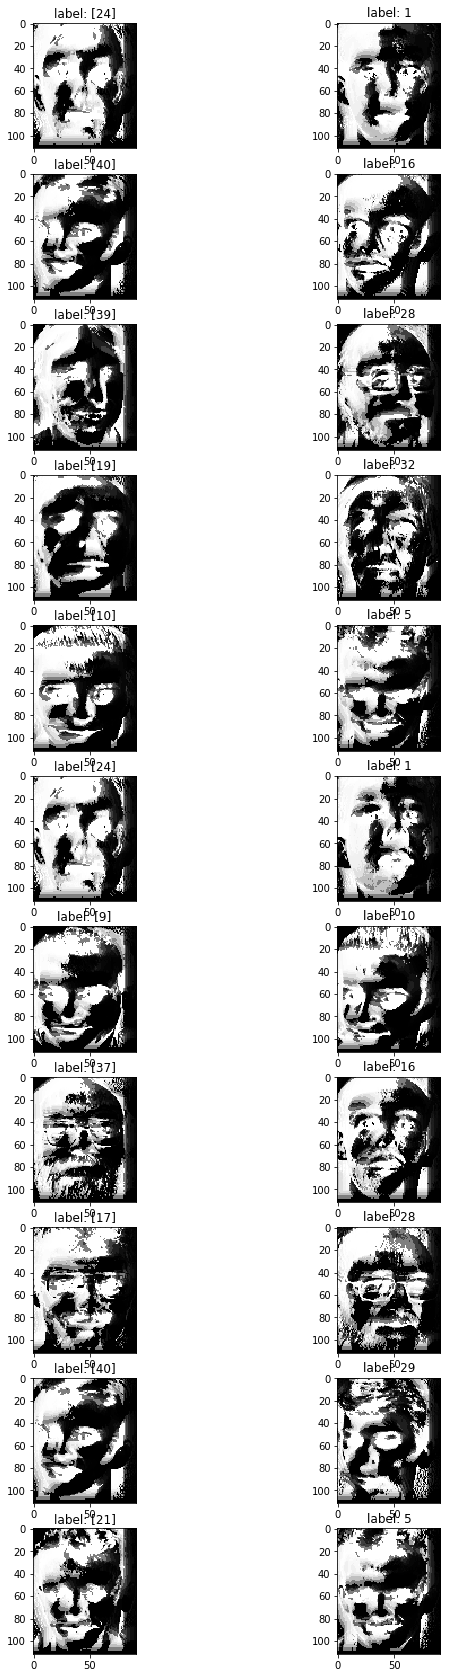

In [44]:
# Normalization using standard_norm method
model_face_recognition(train_lbt,train_labels,test_lbt,test_labels,show_err=True,norm=2,axis=1,figsize=(10,30))

We have good enough accuracy after implementation LBT algorithm. But accuracy is worse then before

In [39]:
#Let's build model using histogram which counts the number of times each of the LBP prototypes appears. 
data_lbt_hist, labels = create_data_matrix_lbp(files,rows,columns,numPoints=24,radius=12,hist=True)

In [40]:
data_lbt_hist.shape

(400, 26)

In [41]:
# split data to train and test
train_lbt_hist, train_labels, test_lbt_hist, test_labels = split_dataset(data_lbt_hist)
print(f'Train set shape: {train_lbt_hist.shape}, train labels shape: {train_labels.shape}')
print(f'Test set shape: {test_lbt_hist.shape}, test labels shape: {test_labels.shape}')

Train set shape: (320, 26), train labels shape: (320, 1)
Test set shape: (80, 26), test labels shape: (80, 1)


In [46]:
#Normalization - substract mean
model_face_recognition(train_lbt_hist,train_labels,test_lbt_hist,test_labels,show_err=False,norm=1,axis=0)

Accuracy for test dataset = 36.25


36.25

In [47]:
#Standardize
model_face_recognition(train_lbt_hist,train_labels,test_lbt_hist,test_labels,show_err=False,norm=2,axis=1)

Accuracy for test dataset = 35.0


35.0

Accuracy is very low. I don't recomen use this algoritm in this case.